# EEG Preprocessing

#### _This is a template that will be parameterised and run via [Papermill](http://papermill.readthedocs.io/) for each subject_

This notebook performs preprocessing of localiser and task data. 

Preprocessing steps:

1. Identification and loading of raw data
2. Maxwell filtering
3. Filtering
4. Epoching
5. Downsampling
6. ICA


## Imports

In [1]:
import os
os.chdir('..')

from mne.io import read_raw_brainvision
import mne
import matplotlib.pyplot as plt
from mne.preprocessing import ICA, create_eog_epochs
import numpy as np
import plotly
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import os
import time
import datetime
import yaml
import papermill as pm
import pandas as pd

%matplotlib inline

np.random.seed(100)

In [2]:
from mne.io import read_raw_brainvision

1. resample 
2. load channel locations/look them up based on standard templates
3. filter the data (I use 0.5 Hz and 45 Hz cutoffs, but depends what you are interested in and what type of filter in built in in that toolbox)
4. re-reference to the average of all channels and bring FCz back in (#1 could also be done here if you like instead, doesn't make much difference) if you do have very noisy channels, they need to be removed before 4 otherwise the average will be altered by these extreme data points and you can then interpolate them after
5. artefact rejection
6. ICA 

## Parameters

In [3]:
data_dir = '../EEG_decoding/data/'  # Directory containing data
session_id = 'e001'  # ID of the scanning session
n_runs = 4  # Number of runs
output_dir = 'data/derivatives'  # Where the output data should go
eye_tracking = True  # If True, eye-tracking measures will be used for exclusion of blink-related ICA components
n_stim = 8  # Number of stimuli
cores = 1  # Number of cores to use for parallel processing
blink_components = None

os.environ['OMP_NUM_THREADS'] = str(cores)

## Get data

Data is stored in [BIDS format](https://www.nature.com/articles/sdata2018110) - currently MNE doesn't directly read from BIDS however.

In [4]:
# Set the data directory for this subject
# data_dir = 'data/'
data_dir = os.path.join(data_dir, 'sub-{0}'.format(session_id), 'ses-01', 'eeg')

# Find all files in the directory and make sure they're in the right order (i.e. ascending)
data = os.listdir(data_dir)
data = sorted([i for i in data if '.vhdr' in i and str(session_id) in i])

# Check we have the right number of runs
# assert len(data) == n_runs, "Wrong number of data files, found {0}".format(len(data))

# See what has been found
print(data)

# Get all the data and read it in
raws = []
run_idx = range(0, n_runs)

# Read in each data set
for i in run_idx:
    start_time = time.time()
    raws.append(read_raw_brainvision(os.path.join(data_dir, data[i]), preload=True))
    time_taken = time.time() - start_time
    print("Time taken = {0}".format(str(datetime.timedelta(seconds=time_taken))))

# Concatenate the runs
raw = mne.concatenate_raws(raws)
del raws  # delete the list of raw data to conserve memory

# Label eye-tracking channels as EOG
# raw.set_channel_types({'UADC001-2910': 'eog', 'UADC002-2901': 'eog', 'UADC003-2901': 'eog'})

['e001B1.vhdr', 'e001b2.vhdr', 'e001b3.vhdr', 'e001b4.vhdr']


<ipython-input-4-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e001\ses-01\eeg\e001B1.vhdr...
Setting channel info structure...
Reading 0 ... 1007049  =      0.000 ...   402.820 secs...
Used Annotations descriptions: ['Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S 10', 'Stimulus/S  1', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  7', 'Stimulus/S  6']
Time taken = 0:00:02.947123


<ipython-input-4-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e001\ses-01\eeg\e001b2.vhdr...
Setting channel info structure...
Reading 0 ... 1018749  =      0.000 ...   407.500 secs...
Used Annotations descriptions: ['Stimulus/S  6', 'Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S 10', 'Stimulus/S  7', 'Stimulus/S  5', 'Stimulus/S  2']
Time taken = 0:00:02.755631


<ipython-input-4-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e001\ses-01\eeg\e001b3.vhdr...
Setting channel info structure...
Reading 0 ... 1078549  =      0.000 ...   431.420 secs...
Used Annotations descriptions: ['Stimulus/S 10', 'Stimulus/S  5', 'Stimulus/S  4', 'Stimulus/S  1', 'Stimulus/S  3', 'Stimulus/S  2', 'Stimulus/S  7', 'Stimulus/S  6']
Time taken = 0:00:02.869329


<ipython-input-4-949389cb721a>:22: DeprecationWarning:

stim_channel (default True in 0.17) will change to False in 0.18 and be removed in 0.19, set it to False in 0.17 to avoid this warning



Extracting parameters from ../EEG_decoding/data/sub-e001\ses-01\eeg\e001b4.vhdr...
Setting channel info structure...
Reading 0 ... 1013299  =      0.000 ...   405.320 secs...
Used Annotations descriptions: ['Stimulus/S  6', 'Stimulus/S  3', 'Stimulus/S  1', 'Stimulus/S  4', 'Stimulus/S 10', 'Stimulus/S  7', 'Stimulus/S  5', 'Stimulus/S  2']
Time taken = 0:00:03.369992


<ipython-input-4-949389cb721a>:27: RuntimeWarning:

Omitted 304 annotation(s) that were outside data range.



In [13]:
raw = raw.resample(500)

601 events found
Event IDs: [ 1  2  3  4  5  6  7 10]
601 events found
Event IDs: [ 1  2  3  4  5  6  7 10]


Effective window size : 4.096 (s)


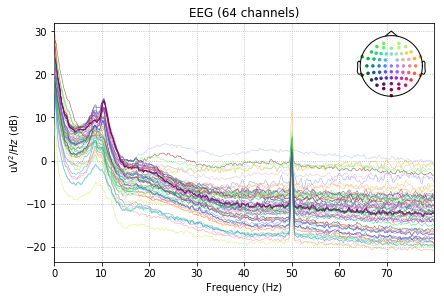

In [16]:
raw.plot_psd(area_mode='range', tmax=10000, show=False, average=False, fmax=80);

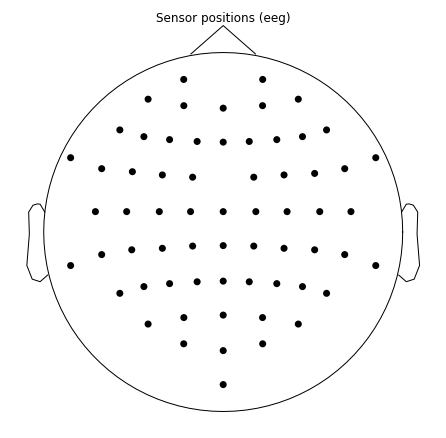

In [17]:
raw.plot_sensors();

## Preprocessing

### Plot the raw data

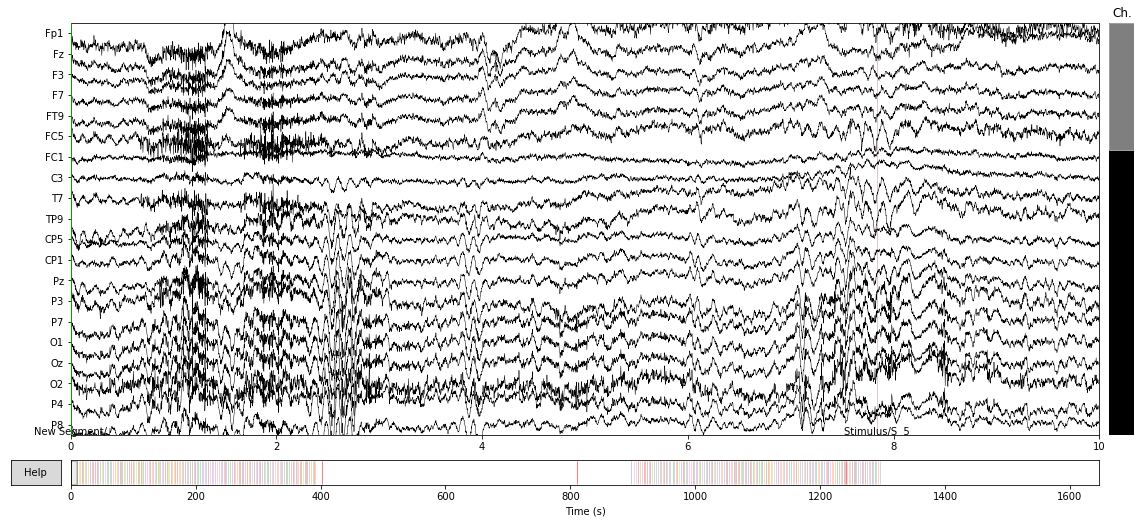

In [18]:
raw.plot();

### Filter

High pass filter above 0.5hz.

FILTERING
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz
Setting up band-pass filter from 0.5 - 45 Hz


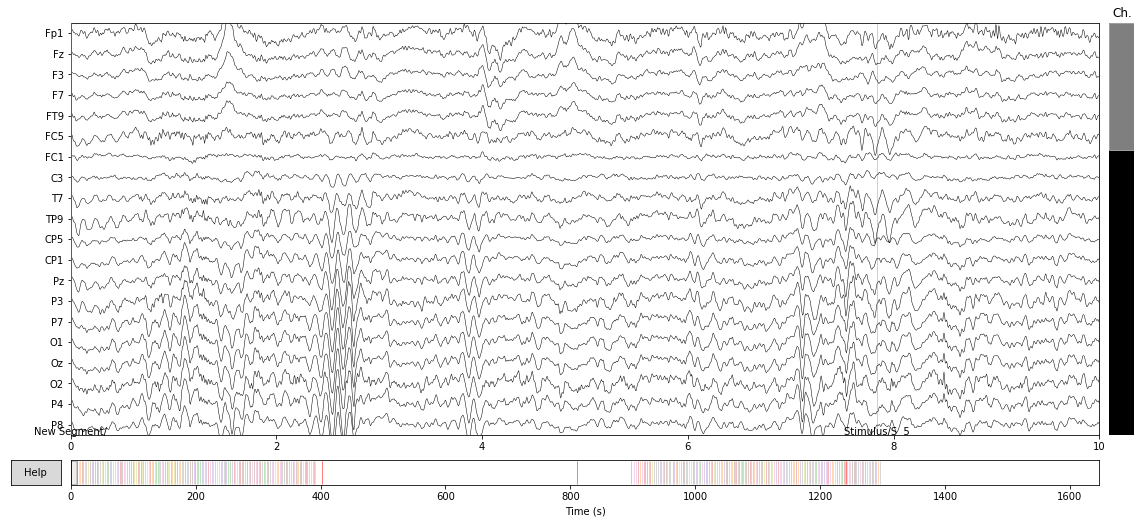

In [19]:
print("FILTERING")
raw.filter(0.5, 45, method='iir')
raw.plot();

In [21]:
raw = mne.add_reference_channels(raw, 'FCz')
montage = mne.channels.read_montage('standard_1020')
raw.set_montage(montage)
raw.del_proj()
raw, _ = mne.set_eeg_reference(raw, 'average', projection=False)

<ipython-input-21-26f034456872>:1: RuntimeWarning:

The locations of multiple reference channels are ignored (set to zero).



Applying a custom EEG reference.
Applying average reference.
Applying a custom EEG reference.


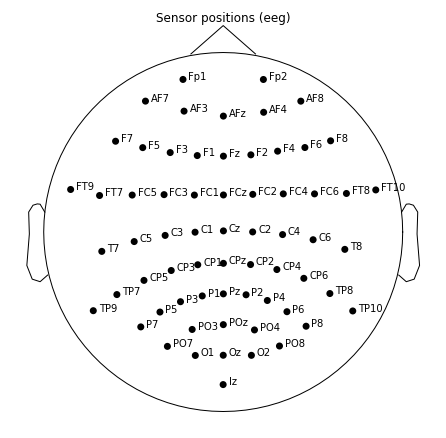

In [22]:
raw.plot_sensors(show_names=True);

## ICA

ICA is performed on the epoched task data (as we have more data here, but we want to apply the same ICA to both localiser and task for consistency in the data we're submitting to the classifer) and is set to find the number of components that explains 95% of the variance. 

We don't do much in terms of selecting noise-related components here - the data is generally pretty clean and doesn't seem to benefit much from extra denoising, so we simply automatically detect blink-related components based on eye-tracking channels.

For some subjects we don't have eye tracking due to equipment problems. If we're not able to identify a blink-related component automatically that may be due to an absent eye tracking channel, or just due to noisy eye tracking data - in this case the notebook raises an error and we can rerun with manually selected components to remove.

Fitting ICA to data using 65 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selection by explained variance: 11 components
Fitting ICA took 2.9s.


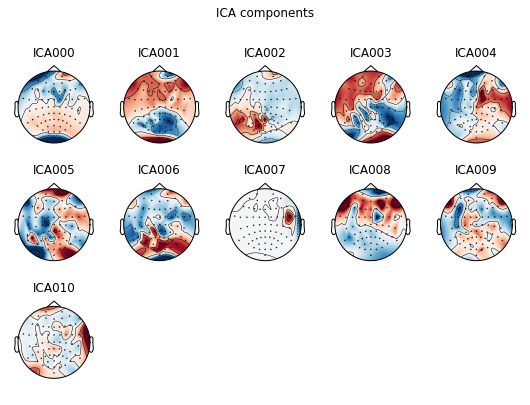

[<Figure size 540x396 with 15 Axes>]

In [23]:
ica = ICA(n_components=0.95, method='fastica',
          random_state=0, max_iter=100).fit(raw, decim=20, reject=None)
ica.plot_components()
# ica.save(os.path.join(output_dir, 'ICA', 'sub-{0}_ses-01_task-AversiveLearningReplay_proc-ICA.fif.gz').format(session_id))


    Using multitaper spectrum estimation with 7 DPSS windows


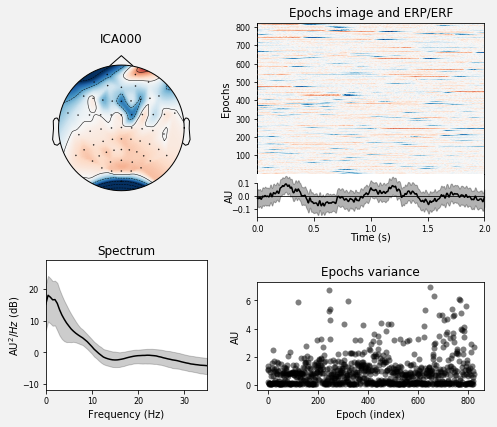

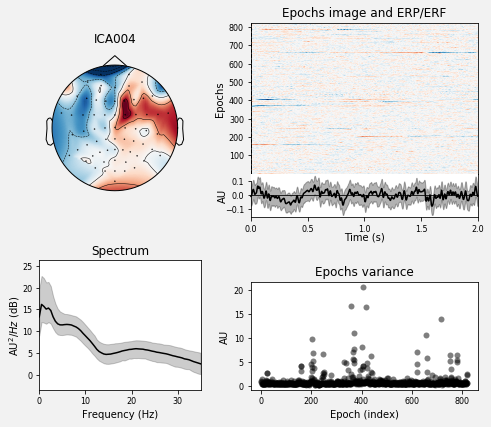

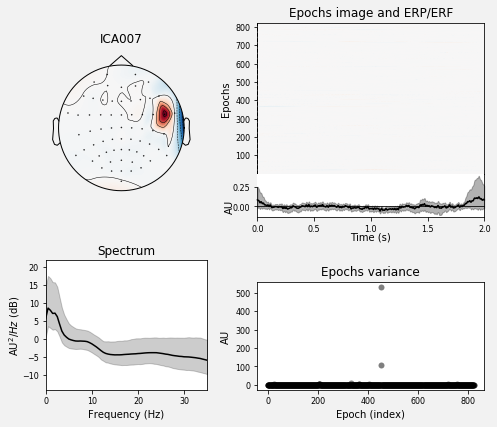

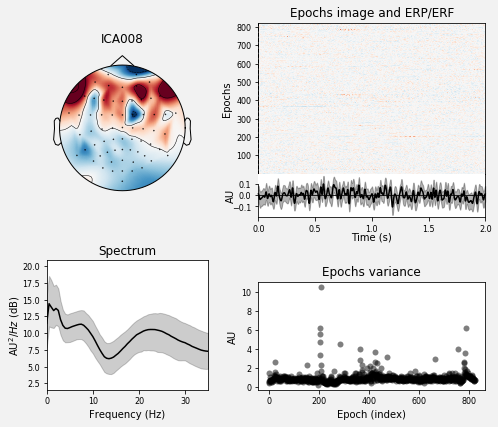

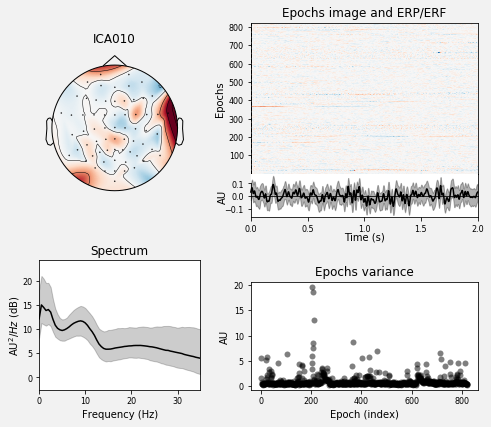

[<Figure size 504x432 with 5 Axes>,
 <Figure size 504x432 with 5 Axes>,
 <Figure size 504x432 with 5 Axes>,
 <Figure size 504x432 with 5 Axes>,
 <Figure size 504x432 with 5 Axes>]

In [24]:
ica.plot_properties(raw, picks=[0, 4, 7, 8, 10], psd_args={'fmax': 35.})

In [25]:
blink_components = [0, 4, 7]

ica.exclude = blink_components
ica.apply(raw)

Transforming to ICA space (11 components)
Zeroing out 3 ICA components


<RawBrainVision  |  e001B1.eeg, n_channels x n_times : 66 x 823530 (1647.1 sec), ~414.8 MB, data loaded>

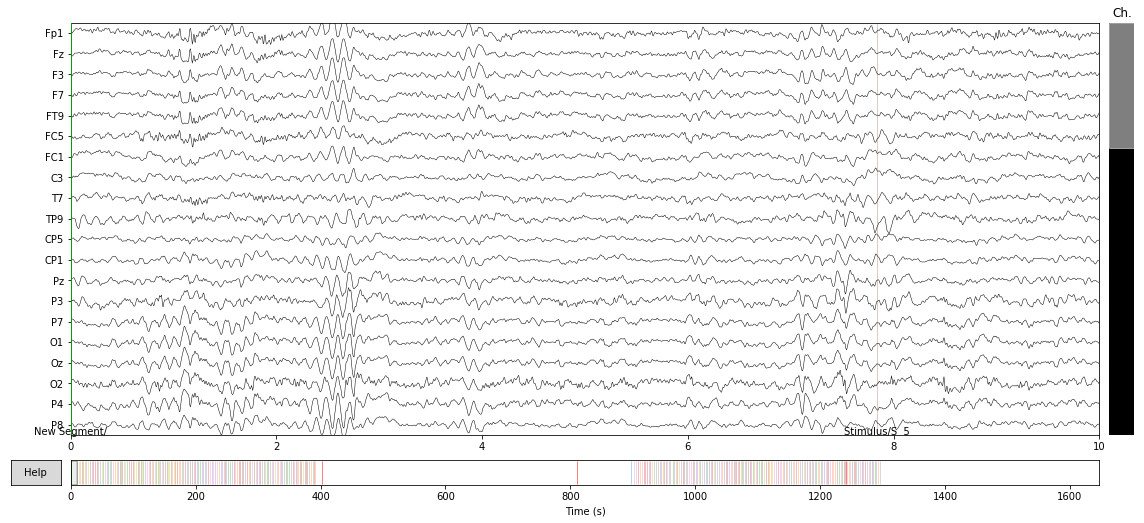

In [26]:
raw.plot();

### Find events

This identifies triggers.

In [27]:
print("FINDING EVENTS")
events = mne.find_events(raw, stim_channel='STI 014', shortest_event=1)

FINDING EVENTS
601 events found
Event IDs: [ 1  2  3  4  5  6  7 10]


### Create epochs

Here we split the continuous data into epochs. Stimulus triggers are from 2 to the number of stimuli * 2 with a step of 2 (this is because sending odd numbers also triggers shocks in the actual task). Code 99 is used for null trials (only used in the localiser). We don't reject any trials because we want to decide on rejections later.

We're only selecting the planning and rest periods from the task here as these are the periods we'll be looking for replay during.

In [28]:
print("EPOCHING")

# reject = dict(eeg=180e-6)
reject = None

# Get event names
# Event numbers for the localiser are even numbers from 2 up to 2 * the number of stimuli
localiser_event_names = dict([('stimulus_{0}'.format(i), i) for i in list(range(1, n_stim, 1)) + [10]])

# Create the epoch objects
localiser_epochs = mne.Epochs(raw, events[np.isin(events[:, 2], list(localiser_event_names.values()))], tmin=-0.1, tmax=0.5, preload=True, event_id=localiser_event_names, reject=reject)

EPOCHING
601 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 601 events and 301 original time points ...
0 bad epochs dropped


In [29]:
print("LOCALISER EVENTS")

for k, v in localiser_event_names.items():
    print("Number of {0} events = {1}".format(k, np.sum(events[:, 2] == v)))
    

LOCALISER EVENTS
Number of stimulus_1 events = 70
Number of stimulus_2 events = 62
Number of stimulus_3 events = 88
Number of stimulus_4 events = 92
Number of stimulus_5 events = 82
Number of stimulus_6 events = 86
Number of stimulus_7 events = 84
Number of stimulus_10 events = 37


### Check the events look right

First, we should have 600 localiser events (or thereabouts - a couple of runs got cut short by a trial or two)

In [30]:
assert len(localiser_epochs) > 590, 'Unexpected number of localiser trials, found {0}, expected 600'.format(len(localiser_epochs))

### Downsample

Resampling to 100hz.

In [31]:
del raw  # Delete the raw data variable to save memory

print("DOWNSAMPLING")
print('Original sampling rate: {0} Hz'.format(localiser_epochs.info['sfreq']))
localiser_epochs = localiser_epochs.copy().resample(100, npad='auto')

DOWNSAMPLING
Original sampling rate: 500.0 Hz


In [32]:
localiser_epochs.info['bads'] = []
picks = localiser_epochs.pick_types(localiser_epochs.info, eeg=True, stim=False, eog=False,
                       include=[], exclude=[])

In [33]:
from autoreject import (AutoReject, set_matplotlib_defaults)
n_interpolates = np.array([1, 4, 32])
consensus_percs = np.linspace(0, 1.0, 11)
ar = AutoReject(n_interpolates, consensus_percs, 
                thresh_method='random_search', random_state=100)

# Note that fitting and transforming can be done on different compatible
# portions of data if needed.


In [34]:
ar.fit(localiser_epochs)
localiser_epochs_clean = ar.transform(localiser_epochs)

Running autoreject on ch_type=eeg
[............................................................] 100.00% Creating augmented epochs /   Computing thresholds ...
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    4.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    5.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  

### Save the epoched data

In [35]:
localiser_epochs_clean.save(os.path.join(output_dir, 'preprocessing/localiser', 'sub-{0}_ses-01_task-AversiveLearningReplay_run-localiser_proc_ICA-epo.fif.gz').format(session_id))

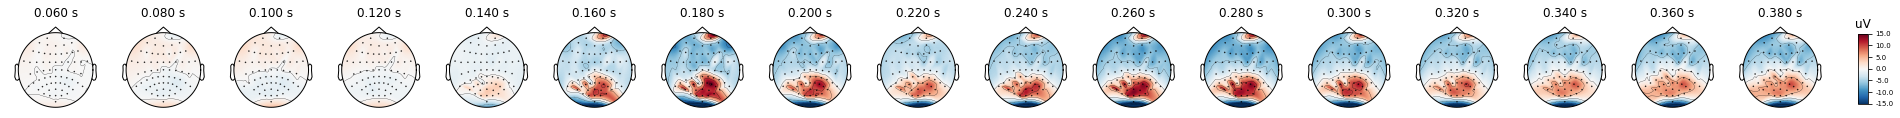

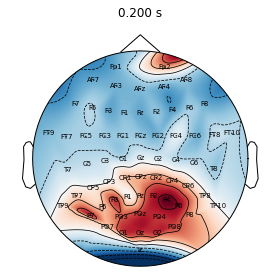

In [36]:
times = np.arange(0.06, 0.4, 0.02)
evoked = localiser_epochs.average()
evoked.plot_topomap(times, ch_type='eeg')
evoked.plot_topomap(0.2, ch_type='eeg', show_names=True, colorbar=False, size=3, res=128);

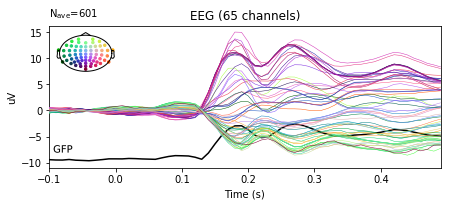

In [37]:
evoked = localiser_epochs.average()
evoked.plot(spatial_colors=True, gfp=True, time_unit='s');

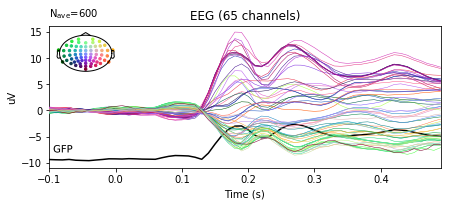

In [38]:
evoked = localiser_epochs_clean.average()
evoked.plot(spatial_colors=True, gfp=True, time_unit='s');